In [71]:
# BASIC DS LIBS
import openpyxl
import numpy as np
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt

# FILE IO LIBS
import os 
from os.path import join 

# GEOSPATIAL LIBS
from osgeo import gdal
import geopandas as gpd
import geopy
from geopandas import GeoDataFrame

# PLOT LIBS
import plotly.express as px 
from plotly.offline import plot
import plotly.graph_objects as go
from shapely.geometry import Point
from plotly.subplots import make_subplots


In [72]:
# IMPORT DATA
hunger_data = pd.read_csv(r'data/foodlink_data.csv')
mealmap_data = pd.read_excel(r'data/MMG2022_2020-2019Data_ToShare.xlsx')
gun_data = pd.read_csv(r'data/Rochester_NY_Shooting_Victims.csv')

## EDA

### DATA CLEANING

##### REMOVING EXCESS VARIABLES AND OBJECTS

In [74]:
gun_data.head()
print(gun_data.columns)
print(gun_data.count())

Index(['X', 'Y', 'ID', 'Case_Number', 'Address', 'Occurred_Date',
       'Occurred_Month', 'Occurred_Year', 'Crime_Type', 'Multiple_Shooting',
       'Gender', 'Race', 'Ethnicity', 'Victim_Age', 'Victim_Age_Band',
       'Latitude', 'Longitude', 'ObjectId'],
      dtype='object')
X                    4679
Y                    4679
ID                   4679
Case_Number          4679
Address              4679
Occurred_Date        4679
Occurred_Month       4679
Occurred_Year        4679
Crime_Type           4679
Multiple_Shooting    4679
Gender               4679
Race                 4679
Ethnicity            4679
Victim_Age           4679
Victim_Age_Band      4679
Latitude             4679
Longitude            4679
ObjectId             4679
dtype: int64


In [75]:
# GUN DATA CLEANING
gun_extras = gun_data[[  'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Crime_Type',
                        'Multiple_Shooting'
]]

gun_data = gun_data.drop(columns=[
                        'ID',
                        'Case_Number',
                        'Occurred_Month',
                        'Gender',
                        'Race',
                        'Ethnicity',
                        'Victim_Age',
                        'Victim_Age_Band',
                        'ObjectId',
                        'Crime_Type',
                        'Multiple_Shooting'
                        ])

gun_data = gun_data.loc[gun_data['Occurred_Year'].isin([2022,2023])]                        
print(gun_data.info())  # to check for any missing values
print("                           GUN VIOLENCE DATA AFTER DATA CLEANING")
gun_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 0 to 436
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              137 non-null    float64
 1   Y              137 non-null    float64
 2   Address        137 non-null    object 
 3   Occurred_Date  137 non-null    object 
 4   Occurred_Year  137 non-null    int64  
 5   Latitude       137 non-null    float64
 6   Longitude      137 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.6+ KB
None
                           GUN VIOLENCE DATA AFTER DATA CLEANING


,X,Y,Address,Occurred_Date,Occurred_Year,Latitude,Longitude
0,-77.610890,43.184163,442 Remington St,2022/06/01 04:00:00+00,2022,43.184163,-77.610890
1,-77.598893,43.181793,904 Hudson Ave,2022/05/29 04:00:00+00,2022,43.181793,-77.598893
2,-77.630378,43.142970,168 Bartlett St,2022/05/29 04:00:00+00,2022,43.142970,-77.630378
3,-77.580628,43.167216,720 N Goodman St,2022/05/28 04:00:00+00,2022,43.167216,-77.580628
4,-77.641972,43.162394,138 Murray St,2022/05/26 04:00:00+00,2022,43.162394,-77.641972


In [77]:
# HUNGER DATA
hunger_data.columns = ['Zip_code', 'Latitude', 'Longitude', 'Food Insecurity Rate']

# NARROW DOWN DATA TO JUST ROCHESTER AREAS
roc_zip = list(range(14604, 14624))
roc_zip.append(14626)
roc_zip.append(14627)
roc_zip.append(14642)
hunger_data = hunger_data.loc[hunger_data['Zip_code'].isin(roc_zip)]

print(hunger_data.info())   # to check for missing values

print("     FOOD INSECURITY DATA AFTER DATA CLEANING")
hunger_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 124 to 145
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Zip_code              20 non-null     int64  
 1   Latitude              20 non-null     float64
 2   Longitude             20 non-null     float64
 3   Food Insecurity Rate  20 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 800.0 bytes
None
     FOOD INSECURITY DATA AFTER DATA CLEANING


,Zip_code,Latitude,Longitude,Food Insecurity Rate
124,14626,43.2141,-77.7135,0.094
127,14623,43.0881,-77.6425,0.167
128,14622,43.2138,-77.5569,0.080
129,14621,43.1863,-77.6018,0.298
130,14620,43.1291,-77.6065,0.187


##### GROUPING GUN VIOLENCE DATA BY ZIP CODE

In [50]:
# USING NOMINATIM TO CONVERT LATITUDES AND LONGITUDES OF GUN VIOENCE DATA INTO ZIP CODES
# THE SERVER FOR GEOCODER HAS BEEN VERY INCONSISTENT (WE KEEP GETTING 502: BAD GATEWAY), SO WE DOWNLOADED THE RESULTING DATAFRAME
# FROM A PREVIOUSLY SUCCESSFUL RUN OF THE CODE INTO A CSV AND CONTINUED WITH THAT FILE
# IF THIS CELL DOES NOT WORK, JUST MOVE ON

from geopy.exc import GeocoderServiceError
from geopy.geocoders import Nominatim
import time
gun_long = gun_data["Longitude"]
gun_lat = gun_data["Latitude"]
zipcode = []
geolocator = Nominatim(user_agent='myapplication')

def reverse_geocode_with_retries(geolocator, lat, long, max_retries=3, delay=5):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.reverse((lat, long), timeout=10)
            return location
        except GeocoderServiceError as e:
            retries += 1
            if retries < max_retries:
                time.sleep(delay)
            else:
                raise e

for i in range(len(gun_lat)):
    location = reverse_geocode_with_retries(geolocator, gun_lat[i], gun_long[i])
    address = location.raw['address']
    zipcode.append(address.get('postcode'))

KeyboardInterrupt: 

In [79]:
# GROUP BY ZIP CODE
gun_data = backup.groupby(["Zip_code"])["X"].count().reset_index(name="count")

# ADD MISSING ZIP CODES
allzip = list(range(14604, 14624))
allzip.append(14626)
allzip.append(14627)
allzip.append(14642)

zip_gun = gun_data["Zip_code"].tolist()
zip_gun = {int(x) for x in zip_gun}
zip_noinclude = list(set(allzip) - set(zip_gun))

for i in range(len(zip_noinclude)):
    gun_data = gun_data.append({'Zip_code': zip_noinclude[i], 'count': 0}, ignore_index=True)

gun_data.rename(columns={'count': 'Number of Shootings'}, inplace=True)

gun_data.head()

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_14064\3431116326.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_14064\3431116326.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_14064\3431116326.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_14064\3431116326.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Jaewon\AppData\Local\Temp\ipykernel_14064\3431116326.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

,Zip_code,Number of Shootings
0,14604,1
1,14605,8
2,14606,9
3,14608,18
4,14609,25


##### MERGE HUNGER AND GUN VIOLENCE DATA

In [53]:
gun_data['Zip_code'] = gun_data['Zip_code'].astype(int)
full_data = pd.merge(hunger_data, gun_data, on='Zip_code')
print("                         FULL DATA SET")
full_data.head(10)

                         FULL DATA SET


,Zip_code,Latitude,Longitude,Food Insecurity Rate,Number of Shootings
0,14626,43.2141,-77.7135,0.094,0
1,14623,43.0881,-77.6425,0.167,0
2,14622,43.2138,-77.5569,0.080,0
3,14621,43.1863,-77.6018,0.298,36
4,14620,43.1291,-77.6065,0.187,0
5,14619,43.1363,-77.6493,0.281,5
6,14618,43.1126,-77.5555,0.077,0
7,14617,43.2242,-77.5951,0.073,0
8,14616,43.2340,-77.6550,0.106,0
9,14615,43.2049,-77.6550,0.190,1


##### SCALE FI RATE AND GUN VIOLENCE RATE

In [54]:
import seaborn as sns

full_data['Food Insecurity Rate'] = (full_data['Food Insecurity Rate']-full_data['Food Insecurity Rate'].min())/(full_data['Food Insecurity Rate'].max()-full_data['Food Insecurity Rate'].min())
full_data['Gun Violence Rate'] = (full_data['Number of Shootings']-full_data['Number of Shootings'].min())/(full_data['Number of Shootings'].max()-full_data['Number of Shootings'].min())

print("                   Scaled Dataset Using Min-Max Normalization")
full_data.head(10)

                   Scaled Dataset Using Min-Max Normalization


,Zip_code,Latitude,Longitude,Food Insecurity Rate,Number of Shootings,Gun Violence Rate
0,14626,43.2141,-77.7135,0.063063,0,0.000000
1,14623,43.0881,-77.6425,0.282282,0,0.000000
2,14622,43.2138,-77.5569,0.021021,0,0.000000
3,14621,43.1863,-77.6018,0.675676,36,1.000000
4,14620,43.1291,-77.6065,0.342342,0,0.000000
5,14619,43.1363,-77.6493,0.624625,5,0.138889
6,14618,43.1126,-77.5555,0.012012,0,0.000000
7,14617,43.2242,-77.5951,0.000000,0,0.000000
8,14616,43.2340,-77.6550,0.099099,0,0.000000
9,14615,43.2049,-77.6550,0.351351,1,0.027778


### PLOTTING BOTH DATASETS

In [55]:
# PLOTTING BOTH CONTINUOUS, NUMERIC VARS
gun_plot = px.scatter_mapbox(
                        data_frame = full_data,
                        lat = full_data['Latitude'],
                        lon = full_data['Longitude'],
                        color= full_data['Gun Violence Rate'],
                        hover_name = None,
                        hover_data= [full_data['Number of Shootings'], full_data['Gun Violence Rate'], full_data['Zip_code']],
                        size = full_data['Gun Violence Rate'],
                        zoom = 10,
                        mapbox_style = 'open-street-map',
                        title='Rochester Zip Codes by Gun Violence Counts',
                        height = 400,
                        width = 700,
                        color_continuous_scale='RdYlGn_r'
                        )



hunger_plot = px.scatter_mapbox(
                        data_frame = full_data,
                        lat = full_data['Latitude'],
                        lon = full_data['Longitude'],
                        color= full_data['Food Insecurity Rate'],
                        zoom = 10,
                        hover_data = [full_data['Food Insecurity Rate'],
                                      full_data['Zip_code']],
                        size = full_data['Food Insecurity Rate'],
                        mapbox_style = 'open-street-map',
                        title='Rochester Zip Codes by Food Insecurity Rate',
                        height = 400,
                        width = 700,
                        color_continuous_scale='RdYlGn_r'
                )

gun_plot.show()
hunger_plot.show()

#### SUMMARY STATS OF EACH DATASET

In [56]:
# GET STATS
gun_stats = gun_data.describe()
hunger_stats = hunger_data.describe()
full_stats = full_data.describe().loc[:,['Food Insecurity Rate', 'Gun Violence Rate']]

# PRINT STATS
print("           DATA SUMMARY")
print(full_stats)

           DATA SUMMARY
       Food Insecurity Rate  Gun Violence Rate
count             20.000000          20.000000
mean               0.372222           0.184722
std                0.306453           0.285033
min                0.000000           0.000000
25%                0.087838           0.000000
50%                0.342342           0.013889
75%                0.597598           0.270833
max                1.000000           1.000000


### COMPARING DATASETS AND VARIABLES

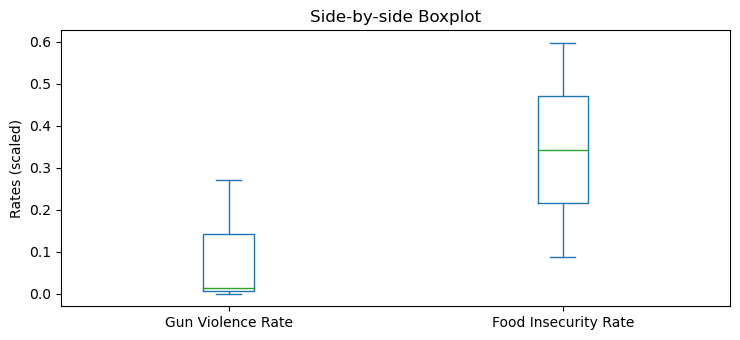

In [57]:
# COMPARE BY BOXPLOT

# GET DATA
gun_boxplot_data = full_data['Gun Violence Rate'].quantile([0.25,0.5,0.75])
hunger_boxplot_data = full_data['Food Insecurity Rate'].quantile([0.25,0.5,0.75])
boxplots = pd.DataFrame({'Gun Violence Rate': gun_boxplot_data, 'Food Insecurity Rate': hunger_boxplot_data})

# SET FIGURE 
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = boxplots[['Gun Violence Rate','Food Insecurity Rate']].plot(kind='box', title='Side-by-side Boxplot')

# Display the plot
plt.ylabel('Rates (scaled)')
plt.show()

### FITTING DISTRIBUTION

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s]


                      FITTING DISTRIBUTION TO GUN VIOLENCE RATE


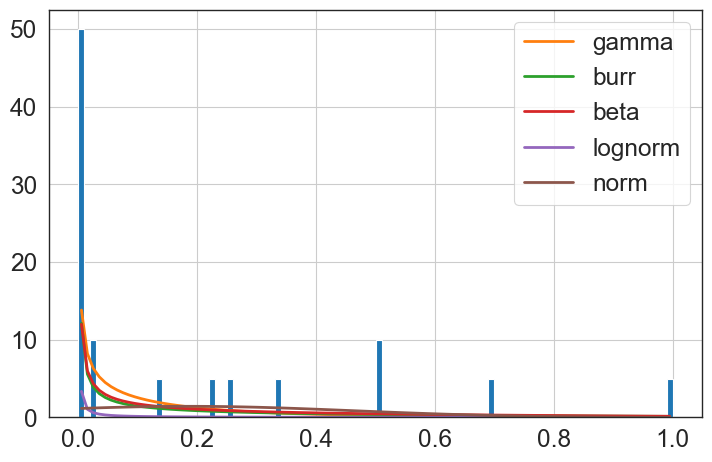

In [58]:
# IMPORT PACKAGES
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

# FIT THE DISTRIBUTION
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=full_data, x="Gun Violence Rate", kind="hist", bins = 100, aspect = 1.5)

gun_rate_distri= full_data["Gun Violence Rate"].values

f = Fitter(gun_rate_distri,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()
print("                      FITTING DISTRIBUTION TO GUN VIOLENCE RATE")

In [59]:
# FIND THE BEST FITTED DISTRIBUTION
f.get_best(method = 'sumsquare_error')

{'gamma': {'a': 0.5633983958684201,
  'loc': -1.2771091412466232e-28,
  'scale': 0.24564143402063493}}

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.87it/s]


                   FITTING DISTRIBUTION TO FOOD INSECURITY RATE


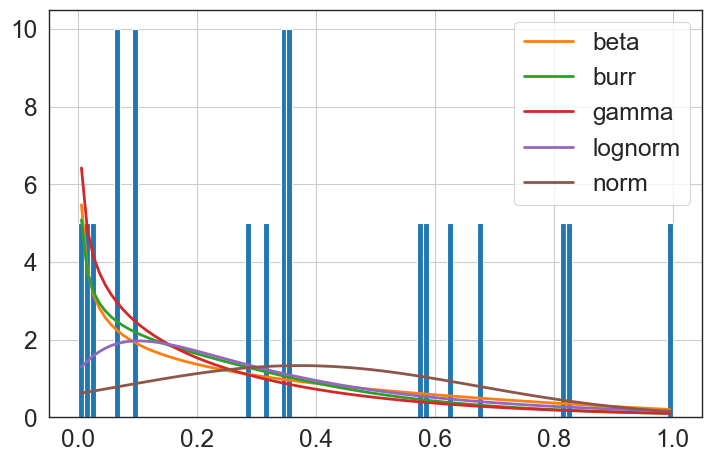

In [60]:
# FIT THE DISTRIBUTION
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=full_data, x="Food Insecurity Rate", kind="hist", bins = 100, aspect = 1.5)

Food_Insecurity = full_data["Food Insecurity Rate"].values

f = Fitter(Food_Insecurity,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()
print("                   FITTING DISTRIBUTION TO FOOD INSECURITY RATE")

In [61]:
# FIND THE BEST FITTED DISTRIBUTION
f.get_best(method = 'sumsquare_error')

{'beta': {'a': 0.6720003002562376,
  'b': 2.1112154187895076,
  'loc': -2.6856690845797166e-30,
  'scale': 1.3244603693469383}}

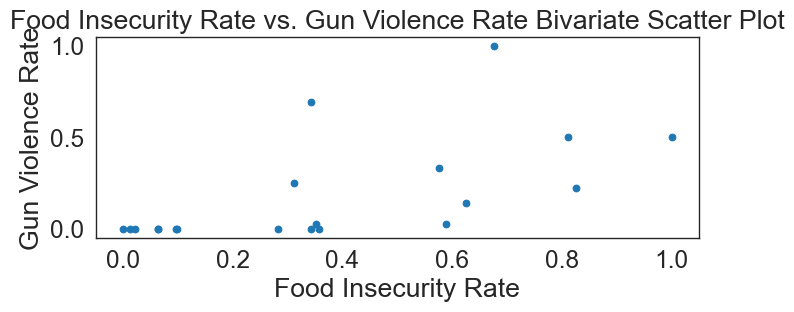

In [62]:
# PLOTTING FI RATE VS GUN VIOLENCE RATE
x = full_data['Food Insecurity Rate']
y = full_data['Gun Violence Rate']

plt.scatter(x, y)
plt.title('Food Insecurity Rate vs. Gun Violence Rate Bivariate Scatter Plot')
plt.xlabel('Food Insecurity Rate')
plt.ylabel('Gun Violence Rate')

plt.show()

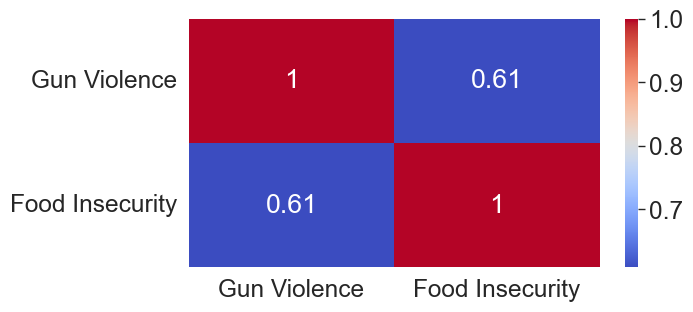

In [65]:
# FORMING CORRELATION MATRIX
df = pd.DataFrame({'Gun Violence': full_data["Gun Violence Rate"], 'Food Insecurity': full_data["Food Insecurity Rate"]})
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

Text(0.5, 0.98, 'Relative Frequency of Gun Violence  Incidents per Zip Code')

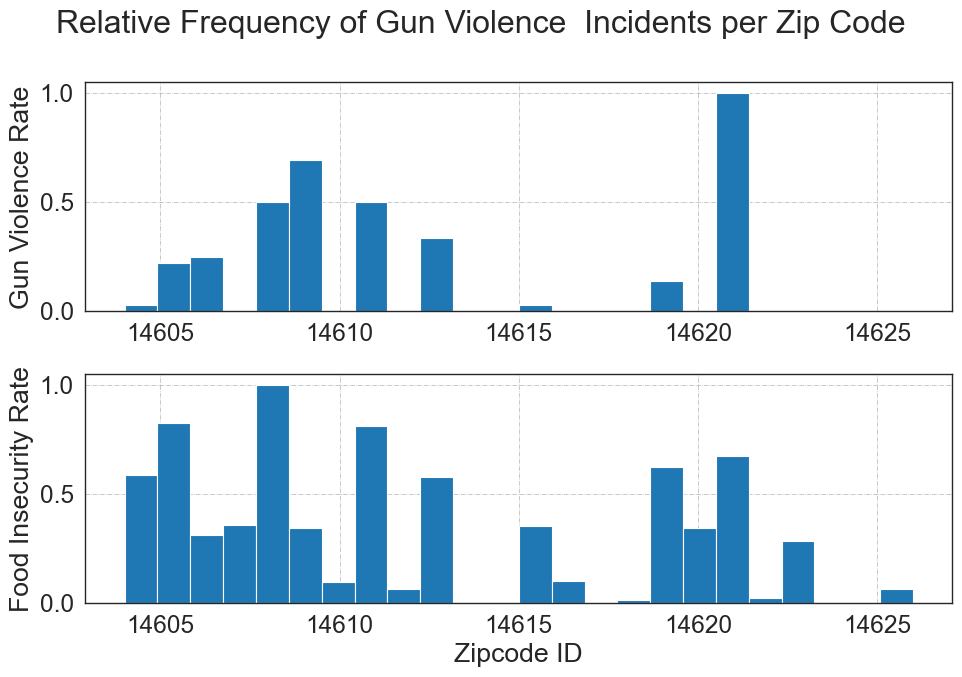

In [66]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(10,7), tight_layout=True)
ax1.grid(visible = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.6)
ax2.grid(visible = True, color = 'grey', linestyle = '-.', linewidth = 0.5, alpha = 0.6)


# CREATE HISTOGRAMS
gun_freq = ax1.hist(x=full_data['Zip_code'], weights = full_data['Gun Violence Rate'], bins = 24)
hunger_freq = ax2.hist(x=full_data['Zip_code'], weights = full_data['Food Insecurity Rate'], bins = 24)


# EXTRA LABELS
plt.xlabel('Zipcode ID')
ax1.set_ylabel('Gun Violence Rate')
ax2.set_ylabel('Food Insecurity Rate')
plt.suptitle("Relative Frequency of Gun Violence  Incidents per Zip Code") 
 

In [80]:
from scipy import stats
stats.shapiro(full_data["Gun Violence Rate"].values)

threshold = 0.6
high_fi = full_data[full_data["Food Insecurity Rate"] >= threshold]
low_fi = full_data[full_data["Food Insecurity Rate"] < threshold]

result = stats.ttest_ind(a=high_fi["Gun Violence Rate"], b=low_fi["Gun Violence Rate"], equal_var=False, alternative='greater')
result

Ttest_indResult(statistic=2.4123177876129285, pvalue=0.030659863211365435)

In [81]:
import pingouin as pg
res = pg.ttest(high_fi["Gun Violence Rate"], low_fi["Gun Violence Rate"], paired=False, alternative='greater')
res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.412318,4.938087,greater,0.03066,"[0.06, inf]",1.632403,5.13,0.91836
